In [140]:
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Dense,LSTM,Dropout,Embedding,Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import re
import spacy
import spacy.cli
from keras.models import Sequential
from keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
# spacy.cli.download("en_core_web_md")

In [24]:
spacy_eng = spacy.load('en_core_web_md')

In [3]:
# Mounting Gdrive
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.environ["KAGGLE_USERNAME"]="jenilgandhi2111111"
os.environ["KAGGLE_KEY"]="55a03338f682b98bf0b113d06857926f"

Mounted at /content/gdrive


In [7]:
%cd /content/gdrive/MyDrive/KaggleDatasets

/content/gdrive/MyDrive/KaggleDatasets


In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:00, 27.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 85.9MB/s]


In [ ]:
!unzip -q /content/gdrive/MyDrive/KaggleDatasets/imdb-dataset-of-50k-movie-reviews.zip -d imdb

In [8]:
%ls

flickr8k/     imdb/                                  kaggle.json
flickr8k.zip  imdb-dataset-of-50k-movie-reviews.zip


In [9]:
df = pd.read_csv("imdb/IMDB Dataset.csv")

In [10]:
df_list = df.values.tolist()

In [11]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

In [12]:
# We need to clean the df_list as it contains impurities like <br> - . etc...
def clean_df(df_lst):
  for i in range(len(df_lst)):
    review = df_lst[i][0]
    sentiment = df_lst[i][1]
    df_lst[i][0] = REPLACE_NO_SPACE.sub("", review.lower())
    df_lst[i][0] = REPLACE_WITH_SPACE.sub(" ",df_lst[i][0])

In [13]:
clean_df(df_list)

In [14]:
df_list

[['one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty p

In [15]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [16]:
df.value_counts(df["sentiment"])
# We can see the dataset is balanced

sentiment
positive    25000
negative    25000
dtype: int64

In [17]:
cleaned_reviews_list = df_list

In [18]:
cleaned_reviews_list

[['one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty p

In [58]:

class Vocab:
  def __init__(self,threshhold=2):
    self.stoi = {"<PAD>":0,"<SOS>":1,"<EOS>":2,"<UNK>":3}
    self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
    self.threshhold = threshhold
    self.tokenizer = spacy_eng.tokenizer

  def build_vocab(self,df_list):
    freq = {}
    idx = 4
    cntr = 0
    for i in df_list:
      # print(cntr)
      cntr += 1
      for word in self.tokenizer(i[0]):
        word = word.text
        if word not in freq:
          freq[word]=1
        else:
          freq[word]+=1
        
        if freq[word] == 2:
          self.stoi[word] = idx
          self.itos[idx] = word
          idx+=1
    print(self.stoi)
  def numericalize(self,df_lst):
    num_captions = []
    self.reviews = []
    for data in df_lst:
      review = data[0]
      if data[1]=="positive":
        sentiment = 1
      else:
        sentiment = 0
      self.reviews.append(sentiment)
      t_lst = []
      for word in spacy_eng.tokenizer(review):
        word = word.text
        if word in self.stoi:
          t_lst.append(self.stoi[word])
        else:
          t_lst.append(self.stoi["<UNK>"])
      num_captions.append(t_lst)
    return num_captions
  
  def convert_captions(self,sent):
    x=[]
    for i in sent:
      x.append(self.itos[i])
    return x
  def __len__(self):
    return len(self.stoi)
  
  def numcapt(self,sent):
    ret_lst = []
    for word in self.tokenizer(sent):
      if word.text in self.stoi:
        ret_lst.append(self.stoi[word.text])
      else:
        ret_lst.append(self.stoi["<UNK>"])
    return ret_lst


In [59]:
v = Vocab(2)
v.build_vocab(df_list)
numericalized = v.numericalize(df_list)
y = v.reviews

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'the': 4, 'that': 5, 'me': 6, 'oz': 7, 'of': 8, 'right': 9, 'this': 10, 'is': 11, 'show': 12, 'with': 13, 'or': 14, 'violence': 15, 'its': 16, 'in': 17, 'word': 18, 'as': 19, 'to': 20, 'it': 21, 'and': 22, 'not': 23, 'on': 24, 'city': 25, 'are': 26, 'where': 27, 'other': 28, 'would': 29, 'for': 30, 'forget': 31, 'nt': 32, 'first': 33, 'episode': 34, 'i': 35, 'struck': 36, 'so': 37, 'was': 38, 'say': 39, 'a': 40, 'high': 41, 'just': 42, 'but': 43, 'll': 44, 'be': 45, 'who': 46, 'away': 47, 'inmates': 48, 'prison': 49, 'due': 50, 'watching': 51, 'you': 52, 'what': 53, 'get': 54, ' ': 55, 'very': 56, 'well': 57, 'has': 58, 'got': 59, 'all': 60, 'can': 61, 'only': 62, 'piece': 63, 'production': 64, 'about': 65, 'one': 66, 'realism': 67, 'home': 68, 'little': 69, 'which': 70, 'use': 71, 'our': 72, 'scenes': 73, 'particularly': 74, 'their': 75, 'wonderful': 76, 'time': 77, 'too': 78, 'hearted': 79, 'comedy': 80, 'may': 81, 'they': 82, 'thought

In [60]:
len(numericalized[0])

310

In [75]:
len(numericalized[0])

310

In [61]:
x = pad_sequences(numericalized,maxlen=250,value = v.stoi["<PAD>"],padding='post')

In [62]:
x[1]

array([   40,    76,    69,    64,    55,     4,  1494,  2711,    11,
          56, 20395,    55,    56,   145,    77,  2754,  1415,    22,
         562,    40,  1198,    22,  1314,  9665,   827,     8,    67,
          20,     4,   691,    63,    55,     4,   293,    26,  1350,
          57,  5753,    55,   139,  4535,    23,    62,    58,    59,
          60,     4,     3,    43,   205,    58,    60,     4,  1519,
          88,  2114,    78,    52,    61,   149,    95,     4,  9102,
         194, 14447,   163,     4,  3818,    20,  2398, 14748,  6676,
          23,    62,    11,    21,    57,   278,     4,    51,    43,
          21,    11,    40, 17615,  1388,    22,  7098,    63,    40,
        7204,    64,    65,    66,     8,     4,    93,  4144,     8,
          80,    22,    90,   108,    55,     4,    67,   174,   380,
          68,    13,     4,    69,   172,     4,  1965,     8,     4,
        1225,    70,   212,    91,    71,     4,  2919,   362,  2257,
        3556,  1063,

In [63]:
x.shape

(50000, 250)

In [64]:
y = np.array(y)

In [65]:
y.shape

(50000,)

In [141]:
# Hyperparameters
embed_size = 128
vocab_size = len(v)
lr = 1e-3

model = Sequential()
model.add(Embedding(vocab_size,embed_size,input_shape=(x.shape[1],)))
model.add(Dropout(0.3))
model.add(LSTM(250,activation="tanh",kernel_regularizer=L1L2(l1=1e-5,l2=1e-4)))
# model.add(LSTM(250,activation="tanh"))
model.add(Dense(1,activation="sigmoid"))



In [142]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 128)          8851968   
_________________________________________________________________
dropout (Dropout)            (None, 250, 128)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 250)               379000    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 251       
Total params: 9,231,219
Trainable params: 9,231,219
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.compile(optimizer=Adam(learning_rate=lr),loss = "binary_crossentropy",metrics=['accuracy'])

In [146]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15)

In [147]:
x_train.shape,y_train.shape

((42500, 250), (42500,))

In [156]:
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_data=(x_test,y_test))

Epoch 1/10
333/333 [==============================] - 43s 129ms/step - loss: 0.1796 - accuracy: 0.9470 - val_loss: 0.3231 - val_accuracy: 0.8820
Epoch 2/10
333/333 [==============================] - 43s 129ms/step - loss: 0.1298 - accuracy: 0.9652 - val_loss: 0.3751 - val_accuracy: 0.8849
Epoch 3/10
 60/333 [====>.........................] - ETA: 33s - loss: 0.1014 - accuracy: 0.9758

KeyboardInterrupt: ignored

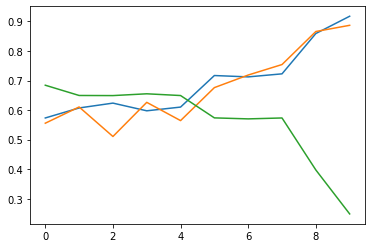

In [157]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history['loss'])

In [162]:
sentence = "if you like me is going to see this in a film history class or something like that at your school try to convince your teacher to see something else believe me anything is better than this movie it is slow paced confusing boring poorly constructed gory gringy do i need to go on its message is good but i have seen them been handled better in several other films the acting isnt even any good this movie is just even more awkward as it start off as being funny not intensional thoughbecause of its surreal story than at the end just becomes uncomfortable to watch i honestly feel like 1 hour and 40 minutes of my life has been robbed why would anyone want to watch a girls describe a threesome for 10 minutes than watch them drive through a traffic jam for 20 minutes listen to a hippie who can make sheep appear witness a sort of rape than see the female lead role eat her husband honestly this movie deserves nothing but a 1 10 and if your not happy with my previewseriously im an open minded guy and i like movies that protest through symbolism but this movie was just awful make any excuse you can to avoid this film"
test_sent = v.numcapt(sentence)
tp = []
tp.append(test_sent)
padded_sent = pad_sequences(tp,maxlen=250,value = v.stoi["<PAD>"],padding='post')
print(padded_sent)

[[  103    52   150     6    11   225    20    95    10    17    40   111
   2299  1524    14   243   150     5   206   332   426   404    20  6698
    332  3645    20    95   243   689   183     6  1632    11   351    91
     10   105    21    11   690  3040  1218   199  1600  3480  4138     3
    170    35   533    20    94    24    16   605    11   142    43    35
     84   190   151   200  2609   351    17   474    28   196     4   195
     11    32   210   272   142    10   105    11    42   210    92  3852
     19    21   696   235    19   120   214    23 19093     3     8    16
   7808   237    91   206     4   229    42   721  3804    20   152    35
    794   457   150   201  1676    22  4720   452     8   146   108    58
    200  9632   326    29   802   514    20   152    40  1598  2762    40
   9633    30   168   452    91   152   151  2587   692    40  8183  9634
     30   752   452  1652    20    40  8628    46    61   140  6333  1347
   3062    40   466     8  1601    91 

In [163]:
model.evaluate(x_test,y_test)

235/235 [==============================] - 2s 8ms/step - loss: 0.3562 - accuracy: 0.8891


[0.3561958372592926, 0.8890666961669922]

In [164]:
model.predict(padded_sent)

array([[0.00331102]], dtype=float32)